# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

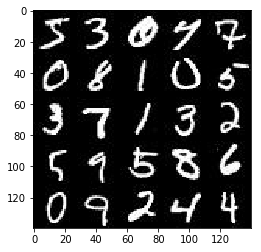

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

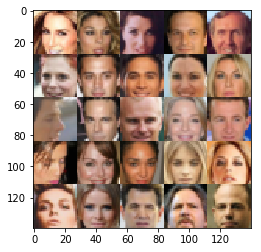

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    
    return  tf.placeholder(tf.float32,[None,image_width,image_height,image_channels]),\
            tf.placeholder(tf.float32,[None,z_dim]),\
            tf.placeholder(tf.float32)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    keep_prob=0.8
    regularizer=0.02
     
    with tf.variable_scope('discriminator', reuse=reuse):
  
        # Input layer is 28x28x3
        x0 = tf.layers.conv2d(images, 64, 5, strides=2, 
                                 padding='same',                             
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=regularizer),
                                 use_bias=False
                             )

        x0 = tf.maximum(alpha * x0, x0)
        x0 = tf.nn.dropout(x0,keep_prob)
        # 14x14x64


        x1 = tf.layers.conv2d(x0, 128, 3, strides=1,                                 
                                 padding='same',                             
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=regularizer),
                                 use_bias=False
                             )
        x1 = tf.layers.batch_normalization(x1, training=True)        
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,keep_prob)
        # 14x14x128
        
        
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2,                                 
                                 padding='same',                             
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=regularizer),
                                 use_bias=False
                             )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,keep_prob)        
        # 7x7x256
        
        
        x3 = tf.layers.conv2d(x2, 512, 3, strides=1,                                 
                                 padding='same',                             
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=regularizer),
                                 use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,keep_prob)        
        # 7x7x512
   
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1,                                                  
                                 activation=None,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer()
                                )
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    keep_prob = 0.8 if is_train else 1
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*512, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer()
                            )
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,keep_prob)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 use_bias=False
                                       )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,keep_prob)        
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',                                       
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 use_bias=False
                                       )

        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,keep_prob)        
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 use_bias=False)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4,keep_prob)        
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 use_bias=False
                                        )

        # 28x28xdepth now

        #we divide by two to scale it to -0.5,0.5 like images
        out = tf.tanh(logits)/2
        


        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real*0.9)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    


    

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    #with tf.name_scope("model_loss"):
    #    tf.summary.histogram('histogram_d_logits_fake',d_logits_fake)
    #    tf.summary.scalar('g_loss',g_loss)
    #    tf.summary.scalar('d_loss',d_loss)
                
        
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    
    samples, losses = [], []
    
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                rescaled_images = batch_images               
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
 
                steps += 1       
                #tb_summary = tf.summary.merge_all()    
                _ = sess.run(d_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})
                #we run twice the generator learning to help it. without that discriminator is too good and generator get lost.
                _ = sess.run(g_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % 10 == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = d_loss.eval({input_z: batch_z, input_real: rescaled_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})

                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g),
                              "Step: ",steps)
                        # Save losses to view after training
                        losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    if data_shape[3]==1:
                        show_generator_output(sess, 25, input_z, 1, "L")
                    if data_shape[3]==3:
                        show_generator_output(sess, 25, input_z, 3, "RGB")
                    
            
    return losses, samples      


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7786... Generator Loss: 0.1984 Step:  10
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.7872 Step:  20
Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 0.3414 Step:  30
Epoch 1/2... Discriminator Loss: 2.6884... Generator Loss: 0.6192 Step:  40
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 1.0760 Step:  50
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.9268 Step:  60
Epoch 1/2... Discriminator Loss: 2.2256... Generator Loss: 0.3668 Step:  70
Epoch 1/2... Discriminator Loss: 1.8288... Generator Loss: 0.5574 Step:  80
Epoch 1/2... Discriminator Loss: 2.1677... Generator Loss: 0.3868 Step:  90
Epoch 1/2... Discriminator Loss: 1.8972... Generator Loss: 0.7432 Step:  100


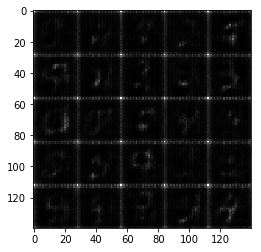

Epoch 1/2... Discriminator Loss: 2.1207... Generator Loss: 0.3136 Step:  110
Epoch 1/2... Discriminator Loss: 2.1484... Generator Loss: 0.3665 Step:  120
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 0.5351 Step:  130
Epoch 1/2... Discriminator Loss: 2.0418... Generator Loss: 0.5822 Step:  140
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.8103 Step:  150
Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 0.9081 Step:  160
Epoch 1/2... Discriminator Loss: 1.7278... Generator Loss: 0.4820 Step:  170
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.7637 Step:  180
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.5475 Step:  190
Epoch 1/2... Discriminator Loss: 1.7009... Generator Loss: 0.7701 Step:  200


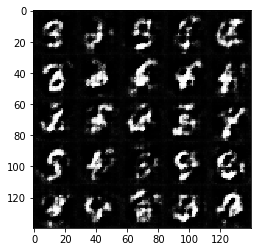

Epoch 1/2... Discriminator Loss: 1.8777... Generator Loss: 0.3562 Step:  210
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 1.2185 Step:  220
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 1.4945 Step:  230
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6853 Step:  240
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.7480 Step:  250
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.3744 Step:  260
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 1.2860 Step:  270
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.9004 Step:  280
Epoch 1/2... Discriminator Loss: 1.6431... Generator Loss: 0.5351 Step:  290
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.5697 Step:  300


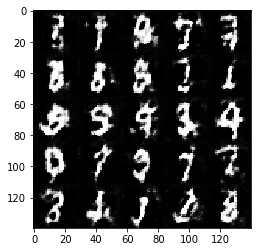

Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.6675 Step:  310
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 1.2819 Step:  320
Epoch 1/2... Discriminator Loss: 1.8764... Generator Loss: 0.5001 Step:  330
Epoch 1/2... Discriminator Loss: 1.7620... Generator Loss: 0.3818 Step:  340
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 1.3230 Step:  350
Epoch 1/2... Discriminator Loss: 1.8436... Generator Loss: 0.8225 Step:  360
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 1.1715 Step:  370
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 1.2683 Step:  380
Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 1.1170 Step:  390
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 0.4634 Step:  400


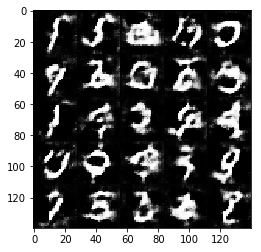

Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.4810 Step:  410
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.7494 Step:  420
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 1.0739 Step:  430
Epoch 1/2... Discriminator Loss: 1.6987... Generator Loss: 0.6087 Step:  440
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 0.4023 Step:  450
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.0774 Step:  460
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 0.4324 Step:  470
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.5274 Step:  480
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 1.0611 Step:  490
Epoch 1/2... Discriminator Loss: 1.5964... Generator Loss: 0.7127 Step:  500


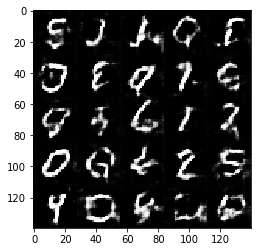

Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.6595 Step:  510
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 1.0845 Step:  520
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.8941 Step:  530
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 1.0333 Step:  540
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.7190 Step:  550
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 1.2451 Step:  560
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 1.0040 Step:  570
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 1.0725 Step:  580
Epoch 1/2... Discriminator Loss: 1.5452... Generator Loss: 0.4694 Step:  590
Epoch 1/2... Discriminator Loss: 1.9002... Generator Loss: 0.4139 Step:  600


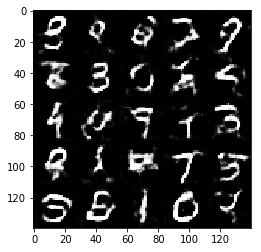

Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.8755 Step:  610
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.9324 Step:  620
Epoch 1/2... Discriminator Loss: 1.7377... Generator Loss: 0.4175 Step:  630
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 1.2005 Step:  640
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.5940 Step:  650
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.7248 Step:  660
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 1.0880 Step:  670
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.1742 Step:  680
Epoch 1/2... Discriminator Loss: 1.8473... Generator Loss: 0.4286 Step:  690
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.2119 Step:  700


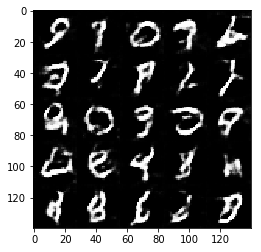

Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.5646 Step:  710
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.8317 Step:  720
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.7263 Step:  730
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.6828 Step:  740
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 1.3385 Step:  750
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.1243 Step:  760
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.6908 Step:  770
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.8149 Step:  780
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.7736 Step:  790
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 1.1746 Step:  800


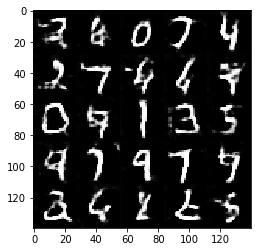

Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.5707 Step:  810
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.7819 Step:  820
Epoch 1/2... Discriminator Loss: 1.7097... Generator Loss: 0.4529 Step:  830
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.7934 Step:  840
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 1.5536 Step:  850
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.0927 Step:  860
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.5391 Step:  870
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.5728 Step:  880
Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 0.6114 Step:  890
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.8026 Step:  900


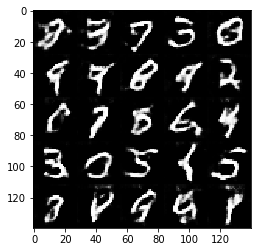

Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 0.8841 Step:  910
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.6266 Step:  920
Epoch 1/2... Discriminator Loss: 1.6407... Generator Loss: 0.4276 Step:  930
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 1.0723 Step:  940
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 1.3349 Step:  950
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 0.9161 Step:  960
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.6115 Step:  970
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.0978 Step:  980
Epoch 1/2... Discriminator Loss: 1.6209... Generator Loss: 0.5240 Step:  990
Epoch 1/2... Discriminator Loss: 2.0840... Generator Loss: 0.2255 Step:  1000


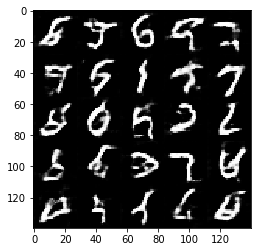

Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.7800 Step:  1010
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.1375 Step:  1020
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.2561 Step:  1030
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 2.2579 Step:  1040
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8212 Step:  1050
Epoch 1/2... Discriminator Loss: 1.2357... Generator Loss: 0.8300 Step:  1060
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.9554 Step:  1070
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8631 Step:  1080
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.8270 Step:  1090
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.0702 Step:  1100


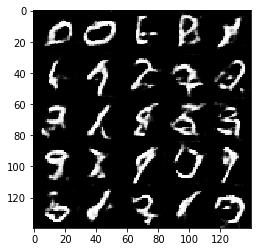

Epoch 1/2... Discriminator Loss: 1.8720... Generator Loss: 0.3432 Step:  1110
Epoch 1/2... Discriminator Loss: 2.0986... Generator Loss: 0.2426 Step:  1120
Epoch 1/2... Discriminator Loss: 1.6088... Generator Loss: 1.3198 Step:  1130
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.7341 Step:  1140
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 1.1098 Step:  1150
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.7751 Step:  1160
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.5861 Step:  1170
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 0.9600 Step:  1180
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.5533 Step:  1190
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.1856 Step:  1200


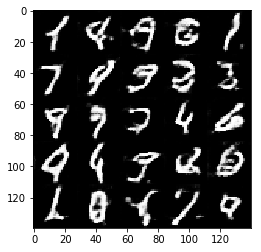

Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.4745 Step:  1210
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 1.6585 Step:  1220
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.5658 Step:  1230
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.3963 Step:  1240
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.9938 Step:  1250
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.5300 Step:  1260
Epoch 1/2... Discriminator Loss: 1.9050... Generator Loss: 2.0635 Step:  1270
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.3767 Step:  1280
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 1.2752 Step:  1290
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.1546 Step:  1300


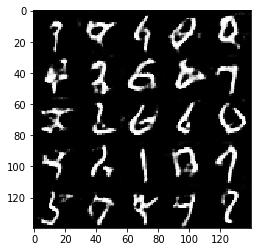

Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.9238 Step:  1310
Epoch 1/2... Discriminator Loss: 1.8615... Generator Loss: 0.3398 Step:  1320
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 1.0860 Step:  1330
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.8816 Step:  1340
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.9796 Step:  1350
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.7527 Step:  1360
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.1947 Step:  1370
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.6395 Step:  1380
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.9872 Step:  1390
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.5638 Step:  1400


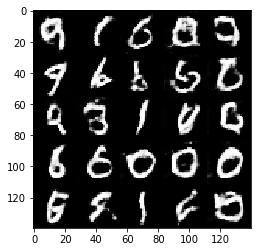

Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.3071 Step:  1410
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.5188 Step:  1420
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.4292 Step:  1430
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 1.3816 Step:  1440
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.4811 Step:  1450
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.6820 Step:  1460
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 0.8416 Step:  1470
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.0219 Step:  1480
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.7449 Step:  1490
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 2.0126 Step:  1500


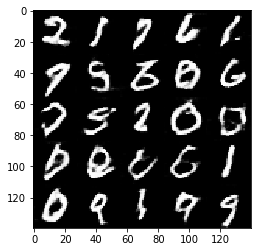

Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.1617 Step:  1510
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.5837 Step:  1520
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.0361 Step:  1530
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.5351 Step:  1540
Epoch 1/2... Discriminator Loss: 2.5025... Generator Loss: 0.1637 Step:  1550
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.8576 Step:  1560
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.8115 Step:  1570
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.0995 Step:  1580
Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 2.2312 Step:  1590
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 0.5129 Step:  1600


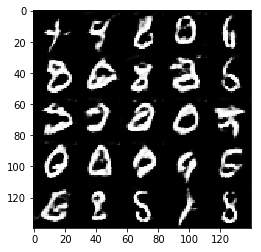

Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.9007 Step:  1610
Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 1.0359 Step:  1620
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.5573 Step:  1630
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.5610 Step:  1640
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 1.0737 Step:  1650
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.7147 Step:  1660
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.9579 Step:  1670
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.7044 Step:  1680
Epoch 1/2... Discriminator Loss: 2.0822... Generator Loss: 0.3017 Step:  1690
Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.4411 Step:  1700


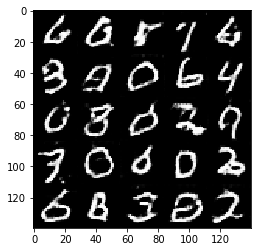

Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.5722 Step:  1710
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 1.3984 Step:  1720
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 1.0285 Step:  1730
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 0.9624 Step:  1740
Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.7151 Step:  1750
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.6461 Step:  1760
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 1.3779 Step:  1770
Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 2.1322 Step:  1780
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.3156 Step:  1790
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.6755 Step:  1800


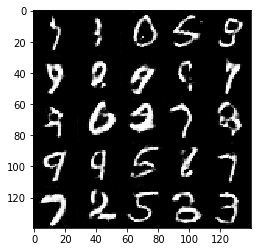

Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 2.1776 Step:  1810
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.8002 Step:  1820
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.9523 Step:  1830
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 0.9060 Step:  1840
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.2072 Step:  1850
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.4616 Step:  1860
Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 1.9482 Step:  1870
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 1.8906 Step:  1880
Epoch 2/2... Discriminator Loss: 1.6428... Generator Loss: 0.2979 Step:  1890
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 2.6344 Step:  1900


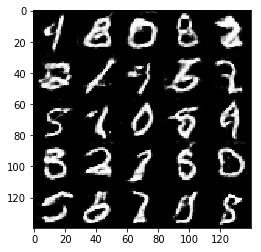

Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 2.4256 Step:  1910
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 2.2692 Step:  1920
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 1.5741 Step:  1930
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 1.2290 Step:  1940
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 0.9788 Step:  1950
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.6277 Step:  1960
Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 0.9909 Step:  1970
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 2.2966 Step:  1980
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 0.6587 Step:  1990
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 1.0463 Step:  2000


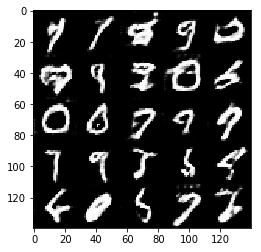

Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 1.5753 Step:  2010
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.1876 Step:  2020
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 1.0979 Step:  2030
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 0.7336 Step:  2040
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 2.2064 Step:  2050
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 1.4121 Step:  2060
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 0.8925 Step:  2070
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 1.2251 Step:  2080
Epoch 2/2... Discriminator Loss: 0.5173... Generator Loss: 1.1917 Step:  2090
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.1677 Step:  2100


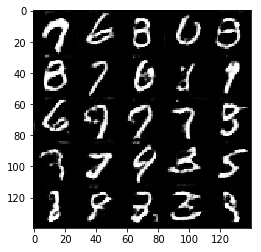

Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 3.8905 Step:  2110
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 2.4867 Step:  2120
Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 2.3706 Step:  2130
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 3.7125 Step:  2140
Epoch 2/2... Discriminator Loss: 0.5637... Generator Loss: 1.3511 Step:  2150
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 1.2281 Step:  2160
Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 1.5670 Step:  2170
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 3.5393 Step:  2180
Epoch 2/2... Discriminator Loss: 0.2421... Generator Loss: 3.0280 Step:  2190
Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 2.5734 Step:  2200


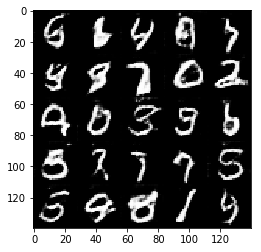

Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 2.7176 Step:  2210
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.5127 Step:  2220
Epoch 2/2... Discriminator Loss: 1.5849... Generator Loss: 0.3691 Step:  2230
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 2.3967 Step:  2240
Epoch 2/2... Discriminator Loss: 0.2891... Generator Loss: 1.9006 Step:  2250
Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 0.8528 Step:  2260
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 2.3008 Step:  2270
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 2.2839 Step:  2280
Epoch 2/2... Discriminator Loss: 1.8705... Generator Loss: 0.4689 Step:  2290
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 1.5963 Step:  2300


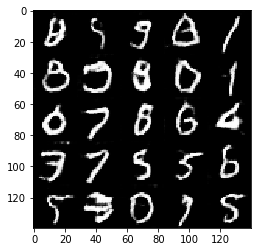

Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 2.6904 Step:  2310
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 1.2862 Step:  2320
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.2047 Step:  2330
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 1.4612 Step:  2340
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.6859 Step:  2350
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.3656 Step:  2360
Epoch 2/2... Discriminator Loss: 0.3316... Generator Loss: 2.3053 Step:  2370
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 2.8004 Step:  2380
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 1.9980 Step:  2390
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7496 Step:  2400


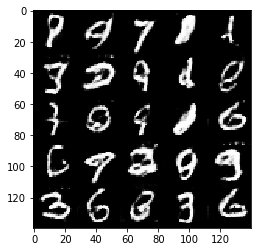

Epoch 2/2... Discriminator Loss: 0.5729... Generator Loss: 2.7748 Step:  2410
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.5126 Step:  2420
Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 2.7299 Step:  2430
Epoch 2/2... Discriminator Loss: 2.1627... Generator Loss: 5.5742 Step:  2440
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 1.0459 Step:  2450
Epoch 2/2... Discriminator Loss: 0.3672... Generator Loss: 2.3041 Step:  2460
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 4.3789 Step:  2470
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.8344 Step:  2480
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 2.8975 Step:  2490
Epoch 2/2... Discriminator Loss: 0.4232... Generator Loss: 1.5248 Step:  2500


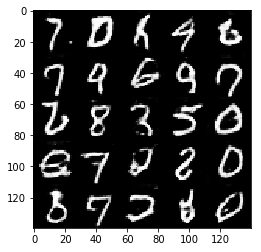

Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 3.6154 Step:  2510
Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 2.8085 Step:  2520
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 1.0517 Step:  2530
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 5.6612 Step:  2540
Epoch 2/2... Discriminator Loss: 0.3248... Generator Loss: 2.6485 Step:  2550
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.6343 Step:  2560
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 3.2842 Step:  2570
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 2.0676 Step:  2580
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.0409 Step:  2590
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 5.1244 Step:  2600


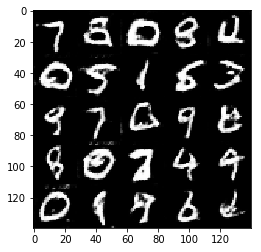

Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 0.7930 Step:  2610
Epoch 2/2... Discriminator Loss: 0.2896... Generator Loss: 2.7832 Step:  2620
Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 2.2294 Step:  2630
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 1.5445 Step:  2640
Epoch 2/2... Discriminator Loss: 0.4200... Generator Loss: 2.1455 Step:  2650
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.5589 Step:  2660
Epoch 2/2... Discriminator Loss: 0.3272... Generator Loss: 2.0420 Step:  2670
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 3.1806 Step:  2680
Epoch 2/2... Discriminator Loss: 0.2280... Generator Loss: 3.4213 Step:  2690
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 4.4644 Step:  2700


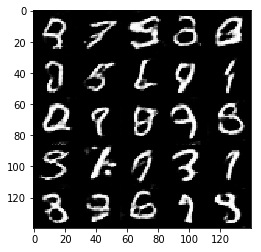

Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 0.7413 Step:  2710
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 1.2865 Step:  2720
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 1.4284 Step:  2730
Epoch 2/2... Discriminator Loss: 0.3088... Generator Loss: 3.5371 Step:  2740
Epoch 2/2... Discriminator Loss: 0.3776... Generator Loss: 2.8145 Step:  2750
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 1.5026 Step:  2760
Epoch 2/2... Discriminator Loss: 0.3857... Generator Loss: 3.3730 Step:  2770
Epoch 2/2... Discriminator Loss: 0.2145... Generator Loss: 2.1313 Step:  2780
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.4841 Step:  2790
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 2.8813 Step:  2800


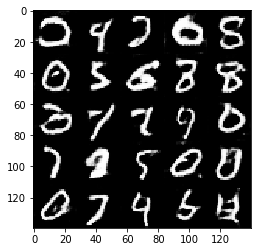

Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 3.1317 Step:  2810
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 2.1203 Step:  2820
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.7451 Step:  2830
Epoch 2/2... Discriminator Loss: 1.9356... Generator Loss: 0.2630 Step:  2840
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 2.1374 Step:  2850
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 2.5521 Step:  2860
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 3.7048 Step:  2870
Epoch 2/2... Discriminator Loss: 0.2558... Generator Loss: 2.6641 Step:  2880
Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 2.2214 Step:  2890
Epoch 2/2... Discriminator Loss: 0.3090... Generator Loss: 2.2176 Step:  2900


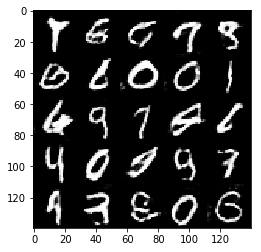

Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 0.9679 Step:  2910
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.0954 Step:  2920
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 1.9742 Step:  2930
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 3.5177 Step:  2940
Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 3.0912 Step:  2950
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 1.9592 Step:  2960
Epoch 2/2... Discriminator Loss: 0.3579... Generator Loss: 4.7345 Step:  2970
Epoch 2/2... Discriminator Loss: 0.3144... Generator Loss: 3.4236 Step:  2980
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 3.6376 Step:  2990
Epoch 2/2... Discriminator Loss: 0.3051... Generator Loss: 1.9514 Step:  3000


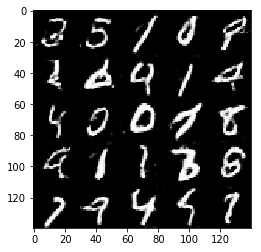

Epoch 2/2... Discriminator Loss: 0.1762... Generator Loss: 3.3064 Step:  3010
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 3.2194 Step:  3020
Epoch 2/2... Discriminator Loss: 0.3066... Generator Loss: 2.6397 Step:  3030
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 1.7728 Step:  3040
Epoch 2/2... Discriminator Loss: 0.2137... Generator Loss: 2.9998 Step:  3050
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 1.9838 Step:  3060
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 3.5953 Step:  3070
Epoch 2/2... Discriminator Loss: 0.1226... Generator Loss: 3.5679 Step:  3080
Epoch 2/2... Discriminator Loss: 0.4504... Generator Loss: 1.4336 Step:  3090
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.6609 Step:  3100


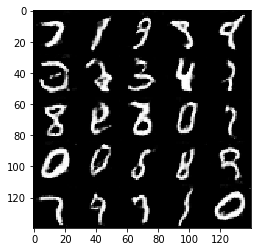

Epoch 2/2... Discriminator Loss: 0.2917... Generator Loss: 2.6708 Step:  3110
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 3.8752 Step:  3120
Epoch 2/2... Discriminator Loss: 0.2852... Generator Loss: 1.8137 Step:  3130
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 1.7770 Step:  3140
Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 1.0914 Step:  3150
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 1.0756 Step:  3160
Epoch 2/2... Discriminator Loss: 0.5385... Generator Loss: 3.1887 Step:  3170
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.1856 Step:  3180
Epoch 2/2... Discriminator Loss: 0.3287... Generator Loss: 2.6012 Step:  3190
Epoch 2/2... Discriminator Loss: 0.2848... Generator Loss: 2.3274 Step:  3200


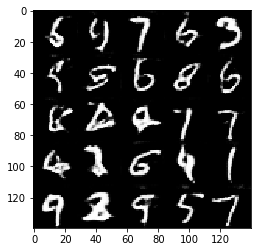

Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 2.2377 Step:  3210
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 0.7892 Step:  3220
Epoch 2/2... Discriminator Loss: 2.3002... Generator Loss: 0.1246 Step:  3230
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.6111 Step:  3240
Epoch 2/2... Discriminator Loss: 2.0792... Generator Loss: 0.3899 Step:  3250
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.1650 Step:  3260
Epoch 2/2... Discriminator Loss: 0.4679... Generator Loss: 3.3070 Step:  3270
Epoch 2/2... Discriminator Loss: 0.3998... Generator Loss: 3.6219 Step:  3280
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.0117 Step:  3290
Epoch 2/2... Discriminator Loss: 0.2814... Generator Loss: 3.3640 Step:  3300


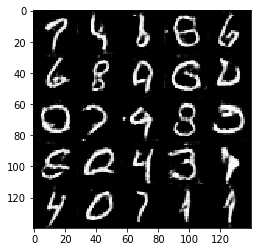

Epoch 2/2... Discriminator Loss: 0.2169... Generator Loss: 3.2245 Step:  3310
Epoch 2/2... Discriminator Loss: 0.2927... Generator Loss: 2.2693 Step:  3320
Epoch 2/2... Discriminator Loss: 0.1580... Generator Loss: 4.6033 Step:  3330
Epoch 2/2... Discriminator Loss: 0.1584... Generator Loss: 2.4416 Step:  3340
Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 3.2563 Step:  3350
Epoch 2/2... Discriminator Loss: 0.2761... Generator Loss: 2.7828 Step:  3360
Epoch 2/2... Discriminator Loss: 0.2524... Generator Loss: 2.7457 Step:  3370
Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 2.5099 Step:  3380
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 4.3374 Step:  3390
Epoch 2/2... Discriminator Loss: 0.1851... Generator Loss: 2.8388 Step:  3400


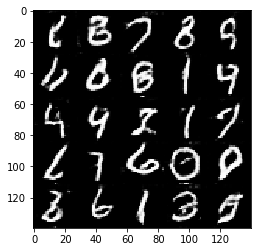

Epoch 2/2... Discriminator Loss: 0.2637... Generator Loss: 2.4924 Step:  3410
Epoch 2/2... Discriminator Loss: 0.2113... Generator Loss: 2.9253 Step:  3420
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 2.6028 Step:  3430
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 2.8304 Step:  3440
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.9604 Step:  3450
Epoch 2/2... Discriminator Loss: 0.2073... Generator Loss: 4.5867 Step:  3460
Epoch 2/2... Discriminator Loss: 0.3238... Generator Loss: 2.3491 Step:  3470
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 2.8177 Step:  3480
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 5.3636 Step:  3490
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 2.0994 Step:  3500


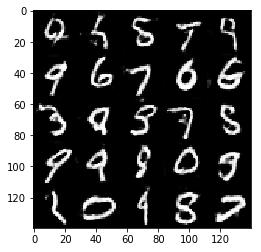

Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.9419 Step:  3510
Epoch 2/2... Discriminator Loss: 0.2652... Generator Loss: 3.9993 Step:  3520
Epoch 2/2... Discriminator Loss: 0.4751... Generator Loss: 3.1335 Step:  3530
Epoch 2/2... Discriminator Loss: 0.2800... Generator Loss: 3.0772 Step:  3540
Epoch 2/2... Discriminator Loss: 0.4353... Generator Loss: 1.5006 Step:  3550
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 4.6505 Step:  3560
Epoch 2/2... Discriminator Loss: 0.2766... Generator Loss: 4.9892 Step:  3570
Epoch 2/2... Discriminator Loss: 0.2373... Generator Loss: 1.9200 Step:  3580
Epoch 2/2... Discriminator Loss: 2.0088... Generator Loss: 6.1150 Step:  3590
Epoch 2/2... Discriminator Loss: 0.7360... Generator Loss: 3.1235 Step:  3600


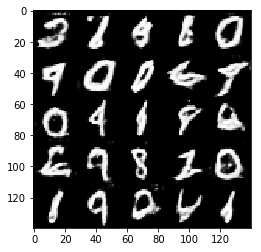

Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 3.5507 Step:  3610
Epoch 2/2... Discriminator Loss: 0.2643... Generator Loss: 3.1405 Step:  3620
Epoch 2/2... Discriminator Loss: 0.1856... Generator Loss: 3.1194 Step:  3630
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 1.4080 Step:  3640
Epoch 2/2... Discriminator Loss: 0.3099... Generator Loss: 2.5819 Step:  3650
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 1.6008 Step:  3660
Epoch 2/2... Discriminator Loss: 0.1181... Generator Loss: 2.3803 Step:  3670
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 5.2511 Step:  3680
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.4373 Step:  3690
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 3.6570 Step:  3700


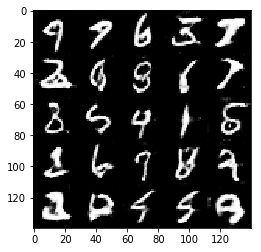

Epoch 2/2... Discriminator Loss: 0.1331... Generator Loss: 1.6396 Step:  3710
Epoch 2/2... Discriminator Loss: 0.1052... Generator Loss: 4.1692 Step:  3720
Epoch 2/2... Discriminator Loss: 0.1927... Generator Loss: 1.9962 Step:  3730
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 5.1897 Step:  3740
Epoch 2/2... Discriminator Loss: 0.4577... Generator Loss: 1.9957 Step:  3750


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8529 Step:  10
Epoch 1/1... Discriminator Loss: 1.9556... Generator Loss: 2.9405 Step:  20
Epoch 1/1... Discriminator Loss: 1.8014... Generator Loss: 0.7108 Step:  30
Epoch 1/1... Discriminator Loss: 2.8468... Generator Loss: 0.2816 Step:  40
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.3047 Step:  50
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.6976 Step:  60
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.4498 Step:  70
Epoch 1/1... Discriminator Loss: 1.9532... Generator Loss: 0.3249 Step:  80
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.3820 Step:  90
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.6010 Step:  100


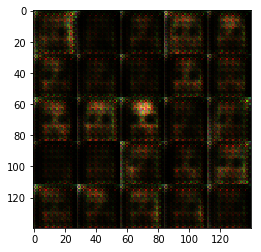

Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.6502 Step:  110
Epoch 1/1... Discriminator Loss: 1.9444... Generator Loss: 0.3430 Step:  120
Epoch 1/1... Discriminator Loss: 2.2082... Generator Loss: 0.2425 Step:  130
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.4757 Step:  140
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.0980 Step:  150
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.1316 Step:  160
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.1041 Step:  170
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 1.2412 Step:  180
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.7567 Step:  190
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.4352 Step:  200


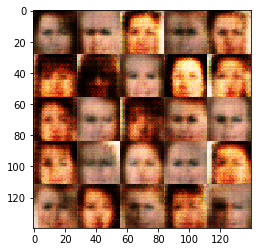

Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 1.3252 Step:  210
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 1.2018 Step:  220
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 1.4832 Step:  230
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 2.5502 Step:  240
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7233 Step:  250
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.9523 Step:  260
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.7750 Step:  270
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.0689 Step:  280
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1794 Step:  290
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 1.2717 Step:  300


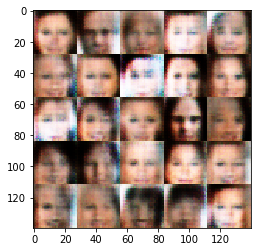

Epoch 1/1... Discriminator Loss: 1.9158... Generator Loss: 2.6477 Step:  310
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.6410 Step:  320
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.5880 Step:  330
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 0.5888 Step:  340
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4617 Step:  350
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.4515 Step:  360
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5416 Step:  370
Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 2.0797 Step:  380
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.7975 Step:  390
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.1268 Step:  400


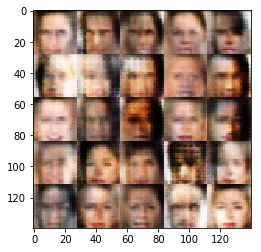

Epoch 1/1... Discriminator Loss: 1.8930... Generator Loss: 0.3596 Step:  410
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6819 Step:  420
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0510 Step:  430
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7302 Step:  440
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 1.1935 Step:  450
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9756 Step:  460
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 0.4706 Step:  470
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8351 Step:  480
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.5754 Step:  490
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8697 Step:  500


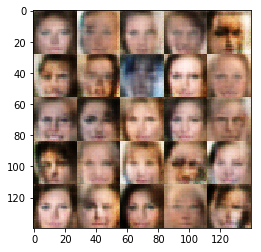

Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.4547 Step:  510
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8498 Step:  520
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.7511 Step:  530
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 1.0883 Step:  540
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.8012 Step:  550
Epoch 1/1... Discriminator Loss: 1.7396... Generator Loss: 0.5231 Step:  560
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8347 Step:  570
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9405 Step:  580
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9499 Step:  590
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.5012 Step:  600


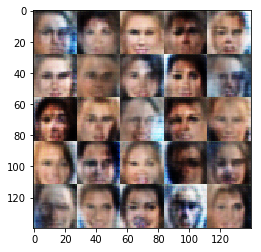

Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.6370 Step:  610
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8235 Step:  620
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7321 Step:  630
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 1.1802 Step:  640
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 0.6067 Step:  650
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 0.6924 Step:  660
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.7011 Step:  670
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5883 Step:  680
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.6773 Step:  690
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5247 Step:  700


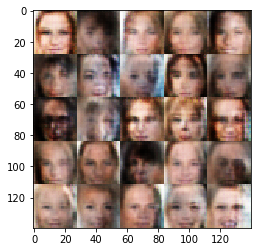

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9413 Step:  710
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6838 Step:  720
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7165 Step:  730
Epoch 1/1... Discriminator Loss: 1.6786... Generator Loss: 0.9025 Step:  740
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.8569 Step:  750
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7118 Step:  760
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.7683 Step:  770
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.7623 Step:  780
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.7437 Step:  790
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7256 Step:  800


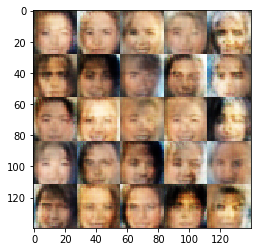

Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.7923 Step:  810
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.6302 Step:  820
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.7237 Step:  830
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.0956 Step:  840
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6028 Step:  850
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 1.0087 Step:  860
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.5587 Step:  870
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.5876 Step:  880
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.7502 Step:  890
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.4990 Step:  900


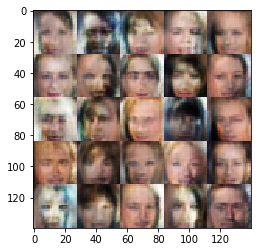

Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.6361 Step:  910
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.3941 Step:  920
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5995 Step:  930
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.6846 Step:  940
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6433 Step:  950
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.6062 Step:  960
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6761 Step:  970
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.6006 Step:  980
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6349 Step:  990
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8215 Step:  1000


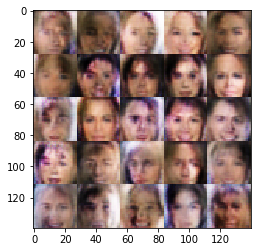

Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.3604 Step:  1010
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.7749 Step:  1020
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.9307 Step:  1030
Epoch 1/1... Discriminator Loss: 2.0168... Generator Loss: 0.5059 Step:  1040
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8791 Step:  1050
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7371 Step:  1060
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7950 Step:  1070
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5683 Step:  1080
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6066 Step:  1090
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5305 Step:  1100


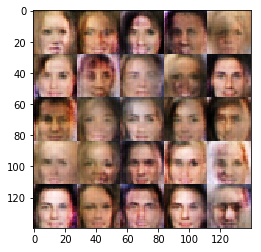

Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.6496 Step:  1110
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.8718 Step:  1120
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8465 Step:  1130
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.7969 Step:  1140
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.8061 Step:  1150
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6354 Step:  1160
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6063 Step:  1170
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3965 Step:  1180
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6448 Step:  1190
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6474 Step:  1200


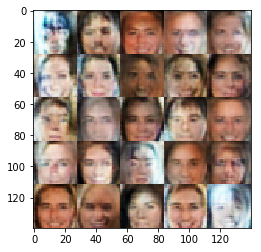

Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.7899 Step:  1210
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6077 Step:  1220
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6310 Step:  1230
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.8201 Step:  1240
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7677 Step:  1250
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.8045 Step:  1260
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7005 Step:  1270
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.5494 Step:  1280
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7103 Step:  1290
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7589 Step:  1300


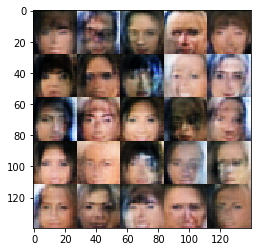

Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.6004 Step:  1310
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.6458 Step:  1320
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8795 Step:  1330
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.8610 Step:  1340
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.8410 Step:  1350
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8428 Step:  1360
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.5839 Step:  1370
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6785 Step:  1380
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.5195 Step:  1390
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8785 Step:  1400


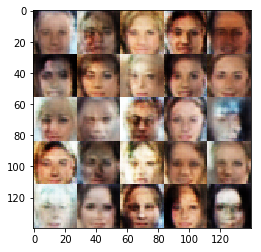

Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5620 Step:  1410
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.6191 Step:  1420
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6120 Step:  1430
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7141 Step:  1440
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 0.7374 Step:  1450
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.4622 Step:  1460
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.6822 Step:  1470
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.7734 Step:  1480
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5620 Step:  1490
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.7298 Step:  1500


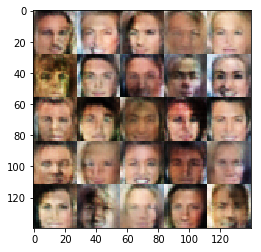

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.6892 Step:  1510
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.5441 Step:  1520
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.5506 Step:  1530
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8359 Step:  1540
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.8168 Step:  1550
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7398 Step:  1560
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.8862 Step:  1570
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6593 Step:  1580
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.4539 Step:  1590
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.5476 Step:  1600


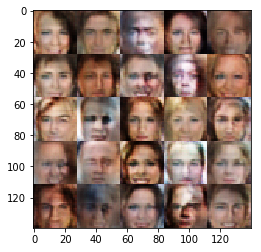

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5728 Step:  1610
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6687 Step:  1620
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.5480 Step:  1630
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.8250 Step:  1640
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.4626 Step:  1650
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5739 Step:  1660
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.4931 Step:  1670
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.5889 Step:  1680
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.9748 Step:  1690
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.5740 Step:  1700


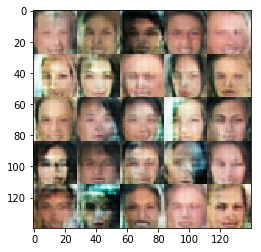

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6959 Step:  1710
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6847 Step:  1720
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7542 Step:  1730
Epoch 1/1... Discriminator Loss: 1.8721... Generator Loss: 0.7124 Step:  1740
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7597 Step:  1750
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.9189 Step:  1760
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5672 Step:  1770
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.7323 Step:  1780
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6609 Step:  1790
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.7777 Step:  1800


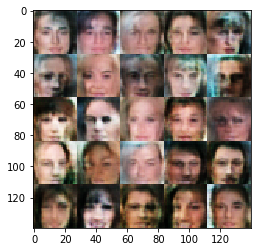

Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7782 Step:  1810
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6857 Step:  1820
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6306 Step:  1830
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.5582 Step:  1840
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.5918 Step:  1850
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.9489 Step:  1860
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5477 Step:  1870
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.5874 Step:  1880
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.4846 Step:  1890
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6747 Step:  1900


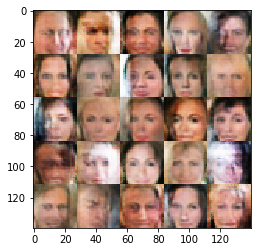

Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7678 Step:  1910
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6115 Step:  1920
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.4163 Step:  1930
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7141 Step:  1940
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.8435 Step:  1950
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.7057 Step:  1960
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.5643 Step:  1970
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.8168 Step:  1980
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6342 Step:  1990
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6993 Step:  2000


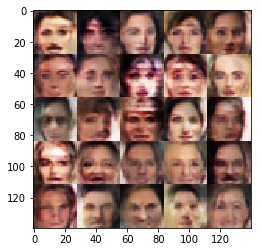

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6607 Step:  2010
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.4374 Step:  2020
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.5743 Step:  2030
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6324 Step:  2040
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.6193 Step:  2050
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.8359 Step:  2060
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.7378 Step:  2070
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6084 Step:  2080
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6814 Step:  2090
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.4121 Step:  2100


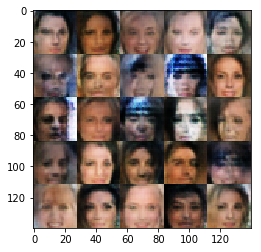

Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.0171 Step:  2110
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6791 Step:  2120
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.7306 Step:  2130
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.3781 Step:  2140
Epoch 1/1... Discriminator Loss: 1.7929... Generator Loss: 0.2996 Step:  2150
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 1.2311 Step:  2160
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.9247 Step:  2170
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5772 Step:  2180
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6129 Step:  2190
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6216 Step:  2200


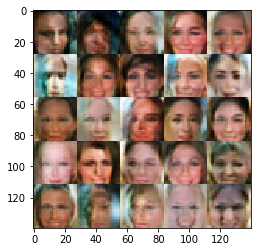

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7678 Step:  2210
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.5428 Step:  2220
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.5233 Step:  2230
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6592 Step:  2240
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6633 Step:  2250
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.4242 Step:  2260
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.4867 Step:  2270
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.5293 Step:  2280
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.4782 Step:  2290
Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.9470 Step:  2300


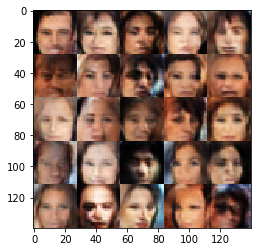

Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.6998 Step:  2310
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.8436 Step:  2320
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5473 Step:  2330
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7444 Step:  2340
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8415 Step:  2350
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5102 Step:  2360
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.8164 Step:  2370
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7145 Step:  2380
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6217 Step:  2390
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6417 Step:  2400


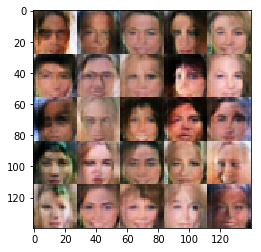

Epoch 1/1... Discriminator Loss: 1.8567... Generator Loss: 0.5122 Step:  2410
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.5992 Step:  2420
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.4394 Step:  2430
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7562 Step:  2440
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.6853 Step:  2450
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.4778 Step:  2460
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.6080 Step:  2470
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5845 Step:  2480
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.8923 Step:  2490
Epoch 1/1... Discriminator Loss: 1.8923... Generator Loss: 0.4831 Step:  2500


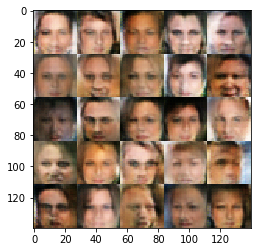

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.9957 Step:  2510
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6381 Step:  2520
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.7217 Step:  2530
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6532 Step:  2540
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.4963 Step:  2550
Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 0.6365 Step:  2560
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6656 Step:  2570
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7015 Step:  2580
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.5497 Step:  2590
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.4829 Step:  2600


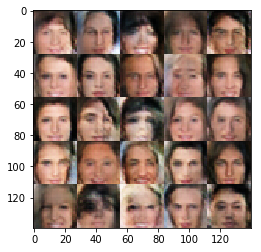

Epoch 1/1... Discriminator Loss: 1.7298... Generator Loss: 0.5643 Step:  2610
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6643 Step:  2620
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.5916 Step:  2630
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.7172 Step:  2640
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8360 Step:  2650
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7276 Step:  2660
Epoch 1/1... Discriminator Loss: 1.7433... Generator Loss: 0.7901 Step:  2670
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5542 Step:  2680
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6907 Step:  2690
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6090 Step:  2700


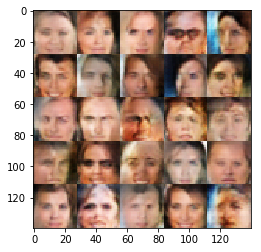

Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.8103 Step:  2710
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6753 Step:  2720
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.4467 Step:  2730
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6713 Step:  2740
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8030 Step:  2750
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.8029 Step:  2760
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.4991 Step:  2770
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5531 Step:  2780
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.8134 Step:  2790
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.4358 Step:  2800


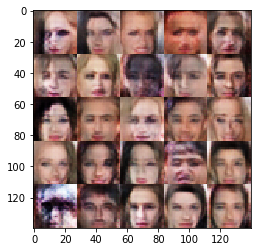

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7057 Step:  2810
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6746 Step:  2820
Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.7839 Step:  2830
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6518 Step:  2840
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7507 Step:  2850
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.5461 Step:  2860
Epoch 1/1... Discriminator Loss: 1.7394... Generator Loss: 0.6309 Step:  2870
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.6656 Step:  2880
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.5452 Step:  2890
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7147 Step:  2900


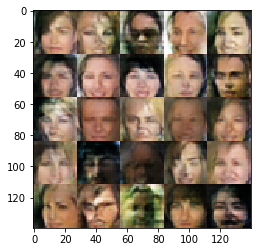

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4887 Step:  2910
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.9180 Step:  2920
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.5168 Step:  2930
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6208 Step:  2940
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6249 Step:  2950
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.8441 Step:  2960
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8658 Step:  2970
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7328 Step:  2980
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.5924 Step:  2990
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7829 Step:  3000


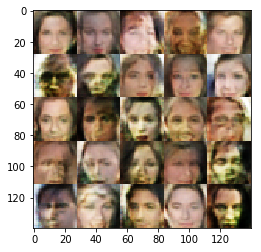

Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.4391 Step:  3010
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6970 Step:  3020
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5811 Step:  3030
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8375 Step:  3040
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.8415 Step:  3050
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.5355 Step:  3060
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.6309 Step:  3070
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6781 Step:  3080
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7111 Step:  3090
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 1.0297 Step:  3100


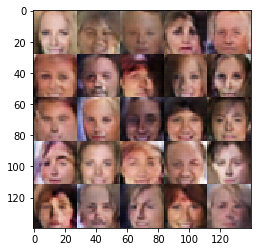

Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.4676 Step:  3110
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4146 Step:  3120
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7157 Step:  3130
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.9528 Step:  3140
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6614 Step:  3150
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8973 Step:  3160
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.5757 Step:  3170
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.8508 Step:  3180
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.3819 Step:  3190
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.5986 Step:  3200


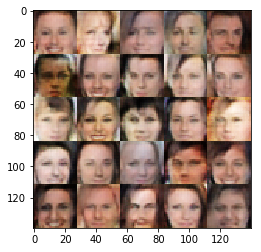

Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8460 Step:  3210
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8060 Step:  3220
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.5416 Step:  3230
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.4622 Step:  3240
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7265 Step:  3250
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.5016 Step:  3260
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.7364 Step:  3270
Epoch 1/1... Discriminator Loss: 1.7267... Generator Loss: 0.5896 Step:  3280
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5746 Step:  3290
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.4427 Step:  3300


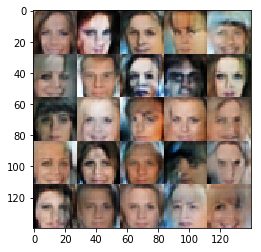

Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.8403 Step:  3310
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6834 Step:  3320
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.5373 Step:  3330
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5847 Step:  3340
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6721 Step:  3350
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8011 Step:  3360
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5514 Step:  3370
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8057 Step:  3380
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.1867 Step:  3390
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7193 Step:  3400


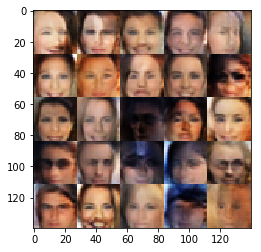

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.5559 Step:  3410
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7512 Step:  3420
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.7565 Step:  3430
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6305 Step:  3440
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6072 Step:  3450
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.5733 Step:  3460
Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 1.2315 Step:  3470
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.3947 Step:  3480
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7781 Step:  3490
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6832 Step:  3500


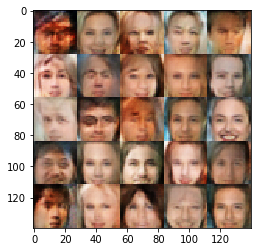

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8205 Step:  3510
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.5380 Step:  3520
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 0.5583 Step:  3530
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.5706 Step:  3540
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7508 Step:  3550
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6717 Step:  3560
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.0572 Step:  3570
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.3752 Step:  3580
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.9429 Step:  3590
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 1.1496 Step:  3600


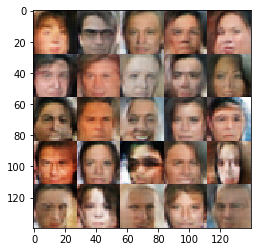

Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4800 Step:  3610
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5042 Step:  3620
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.4859 Step:  3630
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8739 Step:  3640
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.5426 Step:  3650
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.4745 Step:  3660
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5439 Step:  3670
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6829 Step:  3680
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5789 Step:  3690
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7513 Step:  3700


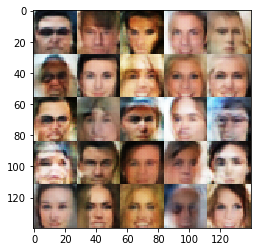

Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.5348 Step:  3710
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 1.0081 Step:  3720
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7621 Step:  3730
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7247 Step:  3740
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7465 Step:  3750
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6190 Step:  3760
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8115 Step:  3770
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.4957 Step:  3780
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4451 Step:  3790
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.4081 Step:  3800


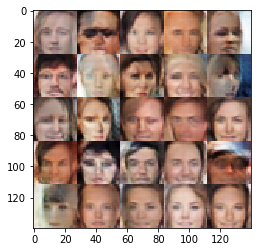

Epoch 1/1... Discriminator Loss: 1.8402... Generator Loss: 0.7050 Step:  3810
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7779 Step:  3820
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.0294 Step:  3830
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.5494 Step:  3840
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6497 Step:  3850
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.5955 Step:  3860
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.8535 Step:  3870
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.5918 Step:  3880
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.0015 Step:  3890
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.5027 Step:  3900


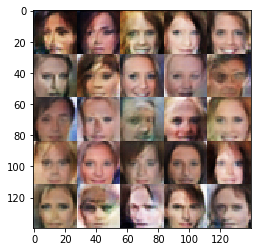

Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.4975 Step:  3910
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.9141 Step:  3920
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.5968 Step:  3930
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.8923 Step:  3940
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6766 Step:  3950
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.8878 Step:  3960
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.9880 Step:  3970
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6326 Step:  3980
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8437 Step:  3990
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7826 Step:  4000


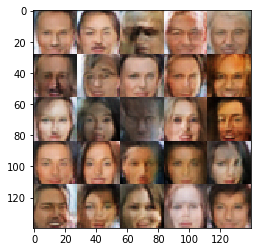

Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.0690 Step:  4010
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.4240 Step:  4020
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.5869 Step:  4030
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.8713 Step:  4040
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5997 Step:  4050
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5466 Step:  4060
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7277 Step:  4070
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 1.0075 Step:  4080
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7649 Step:  4090
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.4851 Step:  4100


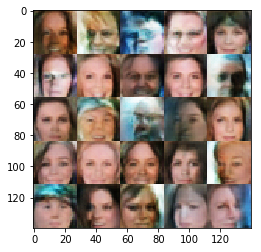

Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.7810 Step:  4110
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7061 Step:  4120
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6316 Step:  4130
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8618 Step:  4140
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8440 Step:  4150
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.6452 Step:  4160
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.5858 Step:  4170
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5807 Step:  4180
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.0627 Step:  4190
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8741 Step:  4200


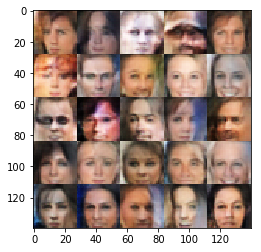

Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 1.5856 Step:  4210
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7012 Step:  4220
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.0381 Step:  4230
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7997 Step:  4240
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 1.1117 Step:  4250
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7890 Step:  4260
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 1.0029 Step:  4270
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8351 Step:  4280
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.9942 Step:  4290
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6310 Step:  4300


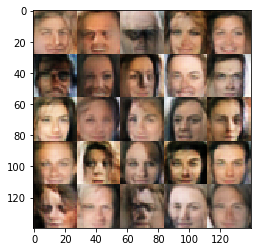

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9335 Step:  4310
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5744 Step:  4320
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7061 Step:  4330
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.3702 Step:  4340
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.4908 Step:  4350
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.4462 Step:  4360
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.5102 Step:  4370
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6060 Step:  4380
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7476 Step:  4390
Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.3811 Step:  4400


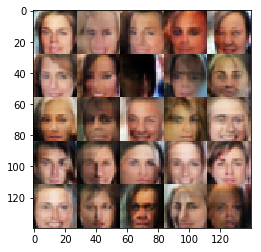

Epoch 1/1... Discriminator Loss: 1.7847... Generator Loss: 0.4091 Step:  4410
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6437 Step:  4420
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6912 Step:  4430
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4836 Step:  4440
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8380 Step:  4450
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.6425 Step:  4460
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.4942 Step:  4470
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.4663 Step:  4480
Epoch 1/1... Discriminator Loss: 1.7755... Generator Loss: 0.2982 Step:  4490
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4719 Step:  4500


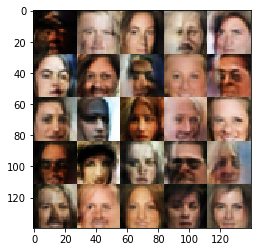

Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0478 Step:  4510
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.4211 Step:  4520
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6066 Step:  4530
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8388 Step:  4540
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.5389 Step:  4550
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.6803 Step:  4560
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5992 Step:  4570
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.6592 Step:  4580
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8232 Step:  4590
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 1.0581 Step:  4600


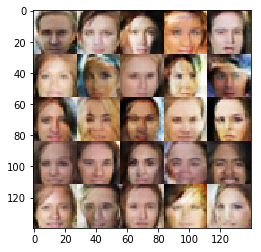

Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.9068 Step:  4610
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.5454 Step:  4620
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 0.5362 Step:  4630
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.5478 Step:  4640
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7890 Step:  4650
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8117 Step:  4660
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8745 Step:  4670
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.4300 Step:  4680
Epoch 1/1... Discriminator Loss: 1.8909... Generator Loss: 0.2744 Step:  4690
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.5704 Step:  4700


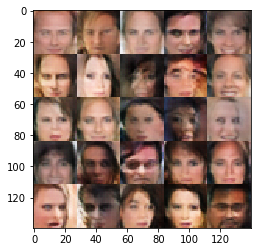

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6300 Step:  4710
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5336 Step:  4720
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8391 Step:  4730
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.4438 Step:  4740
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6389 Step:  4750
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.5694 Step:  4760
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8943 Step:  4770
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7003 Step:  4780
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.0207 Step:  4790
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8704 Step:  4800


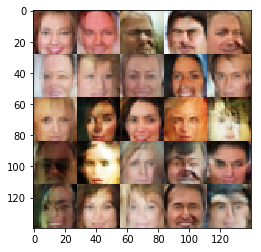

Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5139 Step:  4810
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.0820 Step:  4820
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.1717 Step:  4830
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.7917 Step:  4840
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.9975 Step:  4850
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8142 Step:  4860
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6915 Step:  4870
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.1046 Step:  4880
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6827 Step:  4890
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.5956 Step:  4900


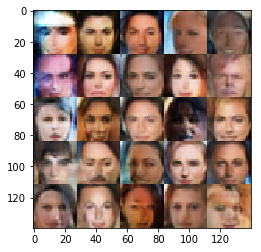

Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7850 Step:  4910
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.5954 Step:  4920
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.6137 Step:  4930
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.0601 Step:  4940
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8312 Step:  4950
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7096 Step:  4960
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5241 Step:  4970
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8920 Step:  4980
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7712 Step:  4990
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8121 Step:  5000


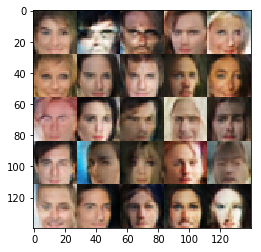

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6564 Step:  5010
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7341 Step:  5020
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.8252 Step:  5030
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8768 Step:  5040
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7203 Step:  5050
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.4363 Step:  5060
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8321 Step:  5070
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7020 Step:  5080
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5154 Step:  5090
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6648 Step:  5100


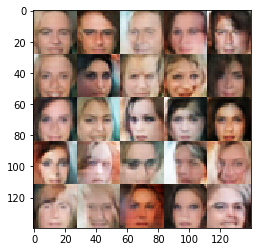

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6924 Step:  5110
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.0334 Step:  5120
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8737 Step:  5130
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8219 Step:  5140
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8376 Step:  5150
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7811 Step:  5160
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.3321 Step:  5170
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6071 Step:  5180
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.5594 Step:  5190
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6449 Step:  5200


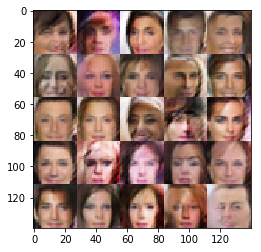

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0217 Step:  5210
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.4658 Step:  5220
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.3651 Step:  5230
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.9234 Step:  5240
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8123 Step:  5250
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8037 Step:  5260
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8513 Step:  5270
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7134 Step:  5280
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.5407 Step:  5290
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9695 Step:  5300


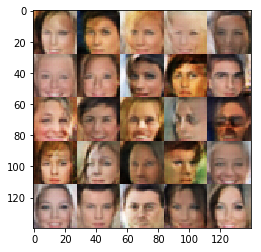

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6570 Step:  5310
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.0653 Step:  5320
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8590 Step:  5330
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6450 Step:  5340
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6746 Step:  5350
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6653 Step:  5360
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.6947 Step:  5370
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 1.3087 Step:  5380
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6111 Step:  5390
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9039 Step:  5400


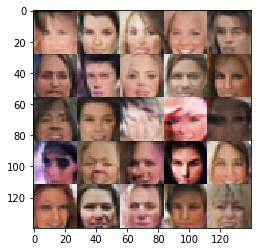

Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6601 Step:  5410
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 1.2980 Step:  5420
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0421 Step:  5430
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5992 Step:  5440
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5438 Step:  5450
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.8685 Step:  5460
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7327 Step:  5470
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.4742 Step:  5480
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.4846 Step:  5490
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4966 Step:  5500


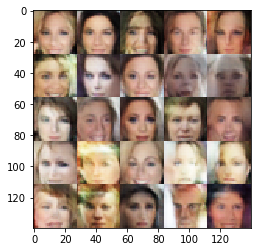

Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.4417 Step:  5510
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.5726 Step:  5520
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.3961 Step:  5530
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.9736 Step:  5540
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5929 Step:  5550
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.4176 Step:  5560
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.6252 Step:  5570
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6921 Step:  5580
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.8983 Step:  5590
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5749 Step:  5600


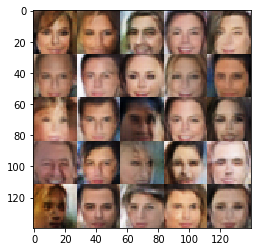

Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5590 Step:  5610
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8047 Step:  5620
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8395 Step:  5630
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.7431 Step:  5640
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.8940 Step:  5650
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.9416 Step:  5660
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6059 Step:  5670
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5635 Step:  5680
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5896 Step:  5690
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6352 Step:  5700


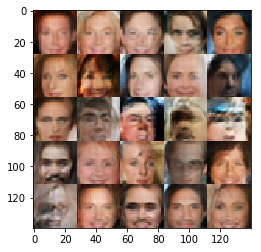

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.1104 Step:  5710
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.1249 Step:  5720
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.2912 Step:  5730
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.6765 Step:  5740
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5251 Step:  5750
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8144 Step:  5760
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7679 Step:  5770
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8631 Step:  5780
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7425 Step:  5790
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9577 Step:  5800


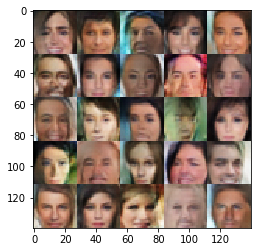

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.5571 Step:  5810
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8051 Step:  5820
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.4932 Step:  5830
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.8000 Step:  5840
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6215 Step:  5850
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9869 Step:  5860
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7948 Step:  5870
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.0548 Step:  5880
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9656 Step:  5890
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5224 Step:  5900


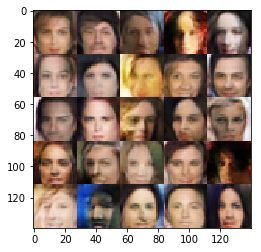

Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0934 Step:  5910
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9614 Step:  5920
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.0631 Step:  5930
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.3351 Step:  5940
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.5423 Step:  5950
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8825 Step:  5960
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7081 Step:  5970
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6371 Step:  5980
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.8595 Step:  5990
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.6963 Step:  6000


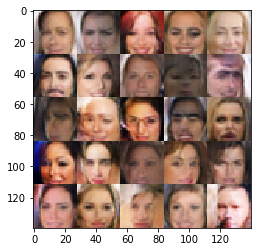

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.4521 Step:  6010
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.0447 Step:  6020
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.9991 Step:  6030
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.2972 Step:  6040
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.4915 Step:  6050
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.0431 Step:  6060
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.8422 Step:  6070
Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 0.7282 Step:  6080
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.9966 Step:  6090
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.1832 Step:  6100


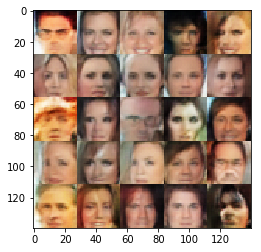

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8227 Step:  6110
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8495 Step:  6120
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.2056 Step:  6130
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.4729 Step:  6140
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.6425 Step:  6150
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6854 Step:  6160
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.8188 Step:  6170
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.8717 Step:  6180
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7185 Step:  6190
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.4628 Step:  6200


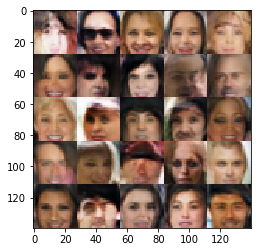

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.3334 Step:  6210
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7239 Step:  6220
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.4745 Step:  6230
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.0205 Step:  6240
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.5119 Step:  6250
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.7339 Step:  6260
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9088 Step:  6270
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.3046 Step:  6280
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9110 Step:  6290
Epoch 1/1... Discriminator Loss: 2.1606... Generator Loss: 1.6453 Step:  6300


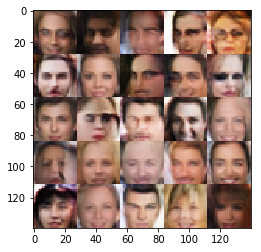

Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.3334 Step:  6310
Epoch 1/1... Discriminator Loss: 1.8423... Generator Loss: 1.3558 Step:  6320
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.0443 Step:  6330


In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.